# Caracterizacion de Potenciales de Accion

La tecnica de registro de actividad neuronal Patch-Clamp nos permite tener registros finamente especificos de la actividad de neuronas unitarias. Mediante esta tecnica de registro es posble registrar los cambios en el potencial electrico de la membrana debido a la activacion, inactivacion, desactivacion y desinactivacion de canales ionicos.

Los valores obtenidos mediante esta tecnica de registro permiten describir el comportamiento de la una neurona ante diferentes intensidades de estimulos. Tipo de variacion que ha sido vital para descubrir dos tipos de respuesta en las neuronas: no-excitatoria y excitatoria. No confundir `no-excitatoria` con `inhibitoria`. Esta ultima es la opuesta al tipo de respuesta excitatoria en el sentido de la polarizacion del estimulo.

Excitatoria: despolariza la membrana celular. Inhibitoria: hyperpolariza la membrana celular.

Las variaciones de respuesta estan dadas principalmente por la cantidad de Potenciales de Accion emitidos en funcion de la intensidad del estimulo. Un analisis que se puede realizar ocn una funcion demasiado basica. Para esta actividad, la caracterizacion de las respuestas de la membrana celular se hara a nivel Potencial de Accion. Para esto, requeriran definir las operaciones internas de las funciones auxiliares que son utilizadas a lo largo de esta libreta, cuya definicion solo contiene un valor `None`.

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importar librerias requeridas**

In [61]:
try:
    import pynwb
except:
    !pip3 install pynwb

In [62]:
import numpy as np
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt

**Definir funciones auxiliares**

In [63]:
def derivada(datos,step=1):
    slopes = []
    for n in range(0, len(datos) - step, step):
        slope = (datos[n] - datos[n - step]) / step
        slopes.append(slope)
    return slopes

def deteccion_umbral(vector):
    for indx in range(len(vector)):
        if vector[indx] >= 10:
            return vector[indx],indx
    return None,None # No es necesario modificar esta linea

def deteccion_umbral_dvdt(vector_data,step=1):
    vector = derivada(vector_data, step=step)
    for indx in range(len(vector)):
        if vector[indx] >= 10:
            position = indx * step
            threshval = vector_data[position]
            return threshval, position
    # Si no se encuentra ningún umbral válido, retornamos un valor predeterminado
    return 0, 0

def extraer_pico(trazo,tiempo,umbral):
    trazo2 = trazo.copy()
    trazo2[trazo < umbral] = -1000
    pico_tiempo = tiempo[trazo2 > -1000]
    pico_trazo = trazo[trazo >= umbral]
    return pico_trazo, pico_tiempo

def atributos_forma(forma,tiempo):
# ESTA FUNCION NO SE MODIFICA
    r_i = None
    d_i = None
    p_i = None

    v_1 = None
    v_2 = None

    maximo = max(forma)
    minimo = min(forma)

    amplitud = maximo-minimo

    for indx in range(len(forma)):
        medida = forma[indx]
        if medida > (minimo + (amplitud*.1)) and r_i is None:
            r_i = indx
        if medida > (minimo + (amplitud*.5)) and v_1 is None:
            v_1 = indx
        if forma[indx] == maximo:
            p_i = indx
        if medida < (minimo + (amplitud*.1)) and not p_i is None:
            d_i = indx
        if medida < (minimo + (amplitud*.5)) and v_2 is None and not p_i is None:
            v_2 = indx

    r_t = tiempo[p_i] - tiempo[r_i]
    d_t = tiempo[d_i] - tiempo[p_i]
    v_t = tiempo[v_2] - tiempo[v_1]

    return r_t,d_t,v_t,amplitud

def extraer_segmento(pclamp,tiempo,inicio,fs,anch_vent):
    p_inicio = int(inicio * fs - anch_vent/2)
    p_final = int(inicio * fs + anch_vent/2)
    segmento_pclamp = pclamp[p_inicio:p_final]
    segmento_tiempo = tiempo[p_inicio:p_final]
    return segmento_pclamp, segmento_tiempo


def crear_df(df_amplitud,df_vdisparo,df_pksancho,df_raisetim,df_decaytim):
    """
        Funcion que organiza los valores de entrada en un DataFrame de Pandas.
        Columnas esperadas: amplitud, voltaje_disparo,ancho_de_pico,tiempo_elevacion,tiempo_caida
    """
    datos = pd.DataFrame({
        'Amplitud':df_amplitud,
        'Voltaje de disparo':df_vdisparo,
        'Ancho de pico':df_pksancho,
        'Tiempo de elevacion':df_raisetim,
        'Tiempo de caida':df_decaytim
    })
    return datos

In [64]:
#from utils import derivada, deteccion_umbral, extraer_pico, atributos_forma, extraer_segmento, deteccion_umbral_dvdt, crear_df

**Seleccionar el archivo con el que se va a trabajar**

Nota: Verifique bien la direccion al archivo.

In [65]:
# raw_io = NWBHDF5IO('data/a_sub-1801-18129009/sub-1801-18129009_icephys.nwb', 'r')
raw_io = NWBHDF5IO('drive/MyDrive/Fenomenos/data/b_sub-1912-2019-11-04-0001/sub-1912-2019-11-04-0001_icephys.nwb', 'r')
nwb_in = raw_io.read()
nwb_cp = nwb_in.copy()

/usr/local/lib/python3.10/dist-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/usr/local/lib/python3.10/dist-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/usr/local/lib/python3.10/dist-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


**Extraer las curvas caracteristicas de los Potenciales de Accion (picos)**

Mediante un analisis exploratorio, podra darse cuenta que los primeros 9 registros corresponden a respuestas no excitatorias/inhibitorias por lo que la iteracion comenzara en el registro 10.

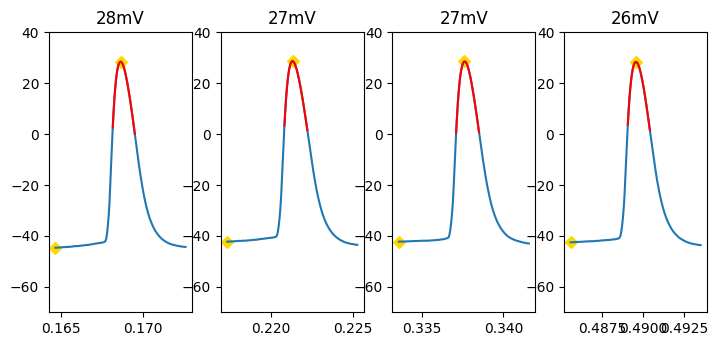

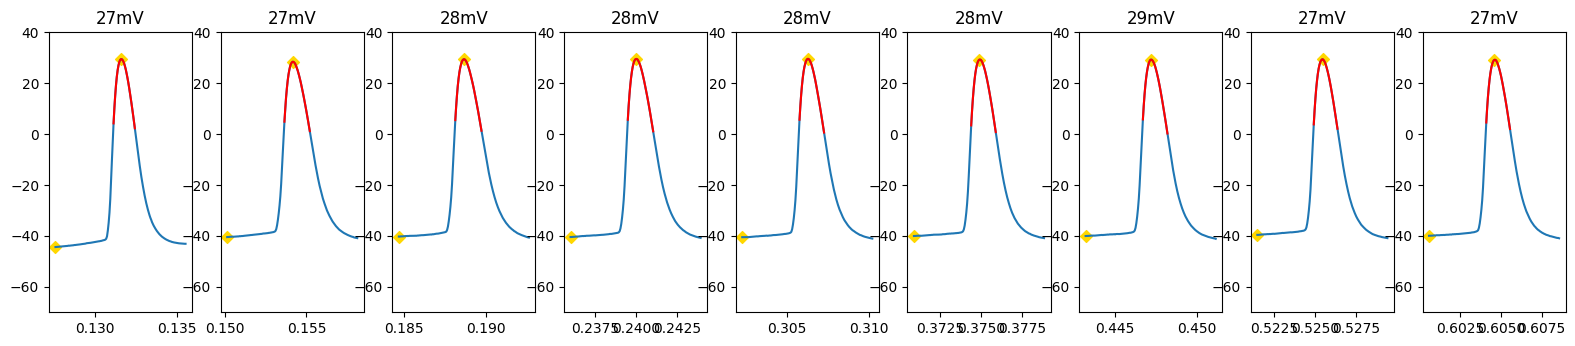

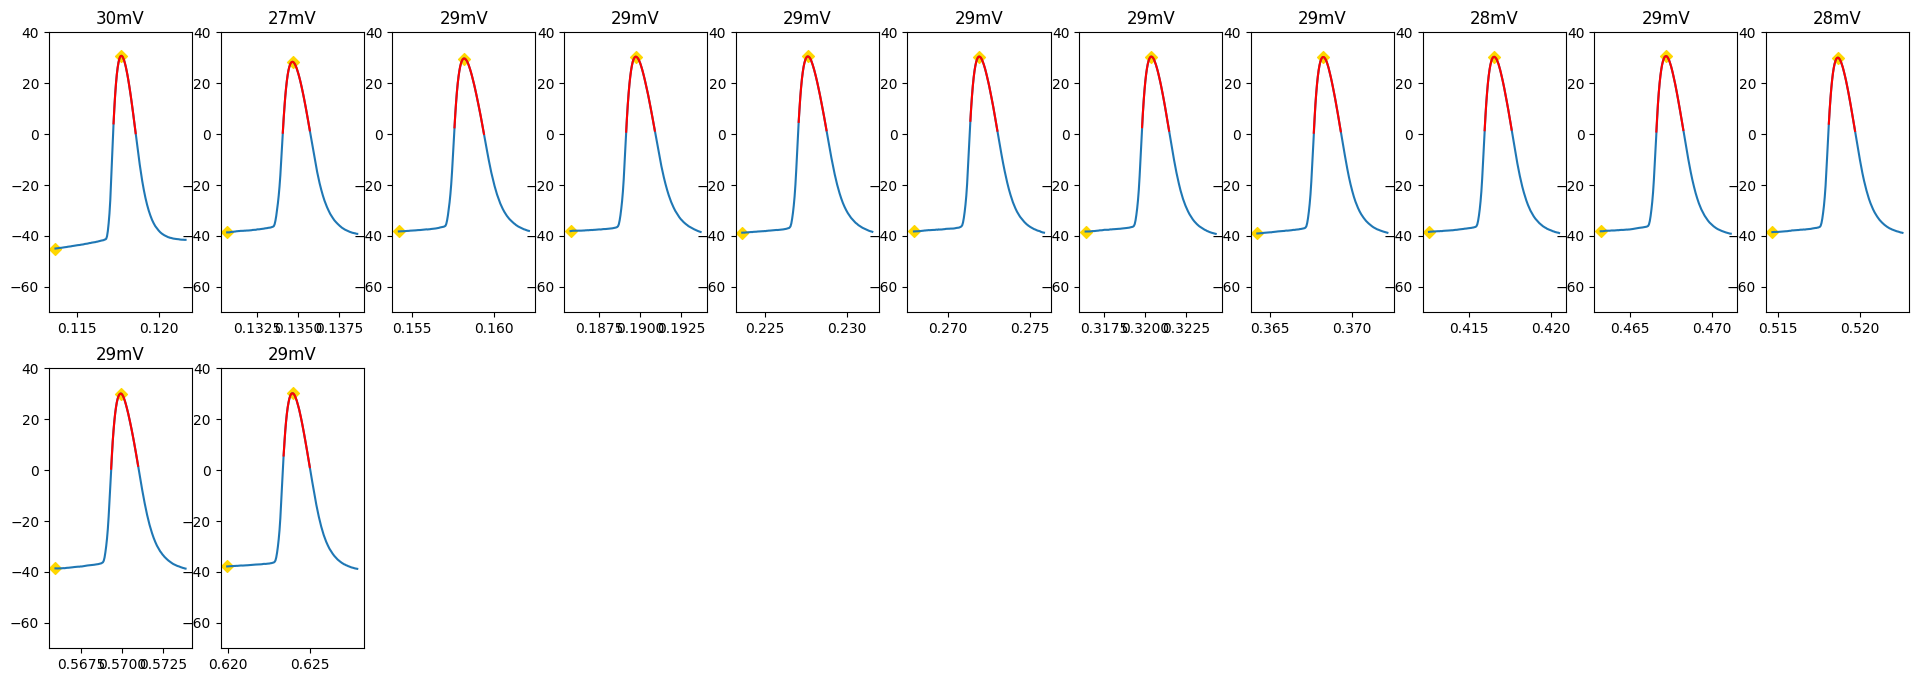

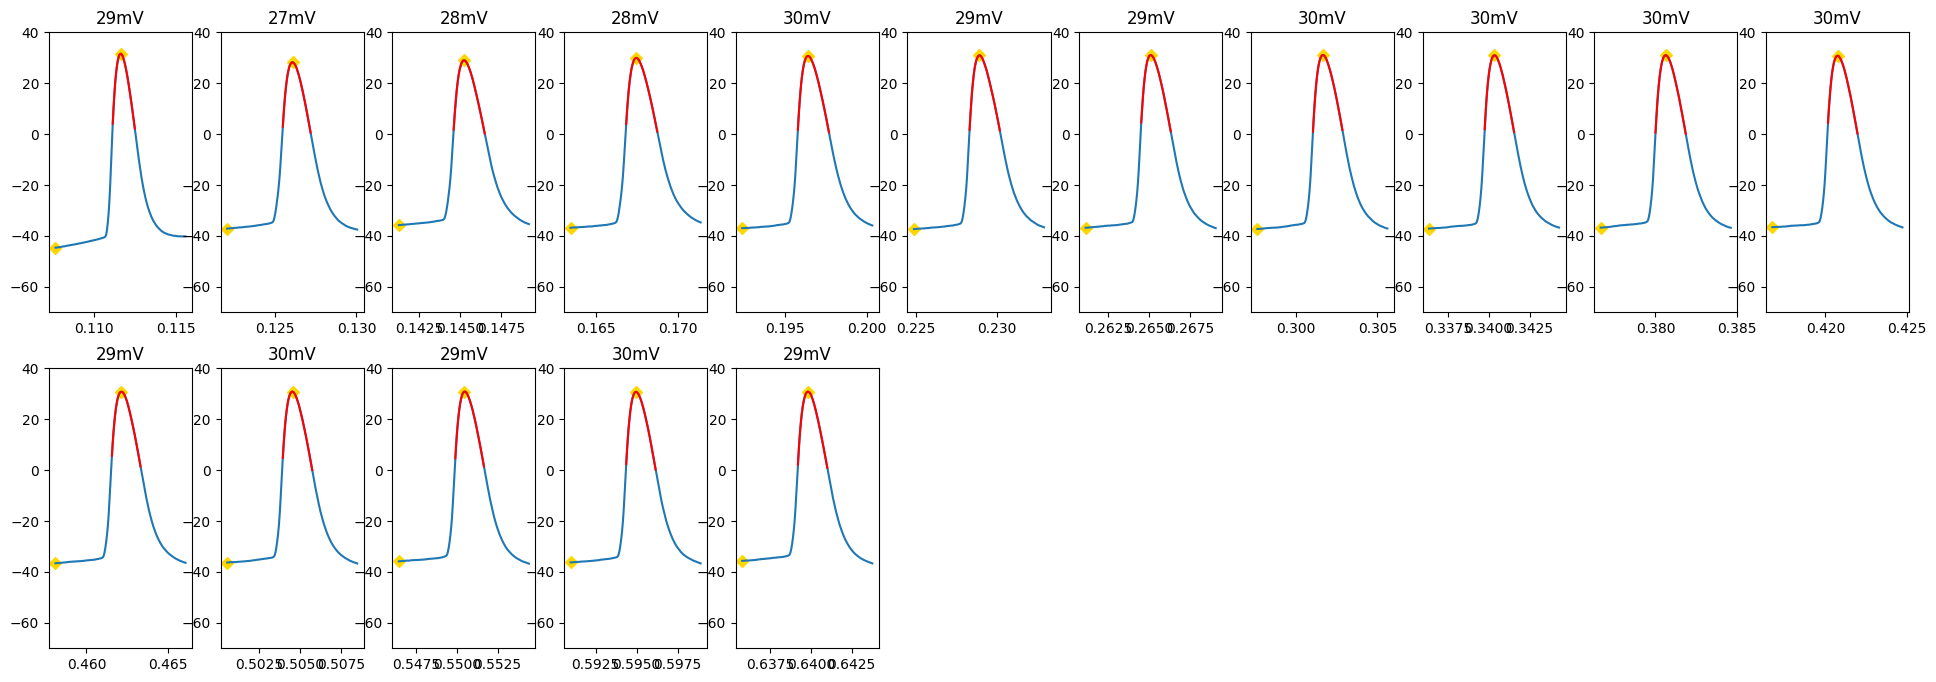

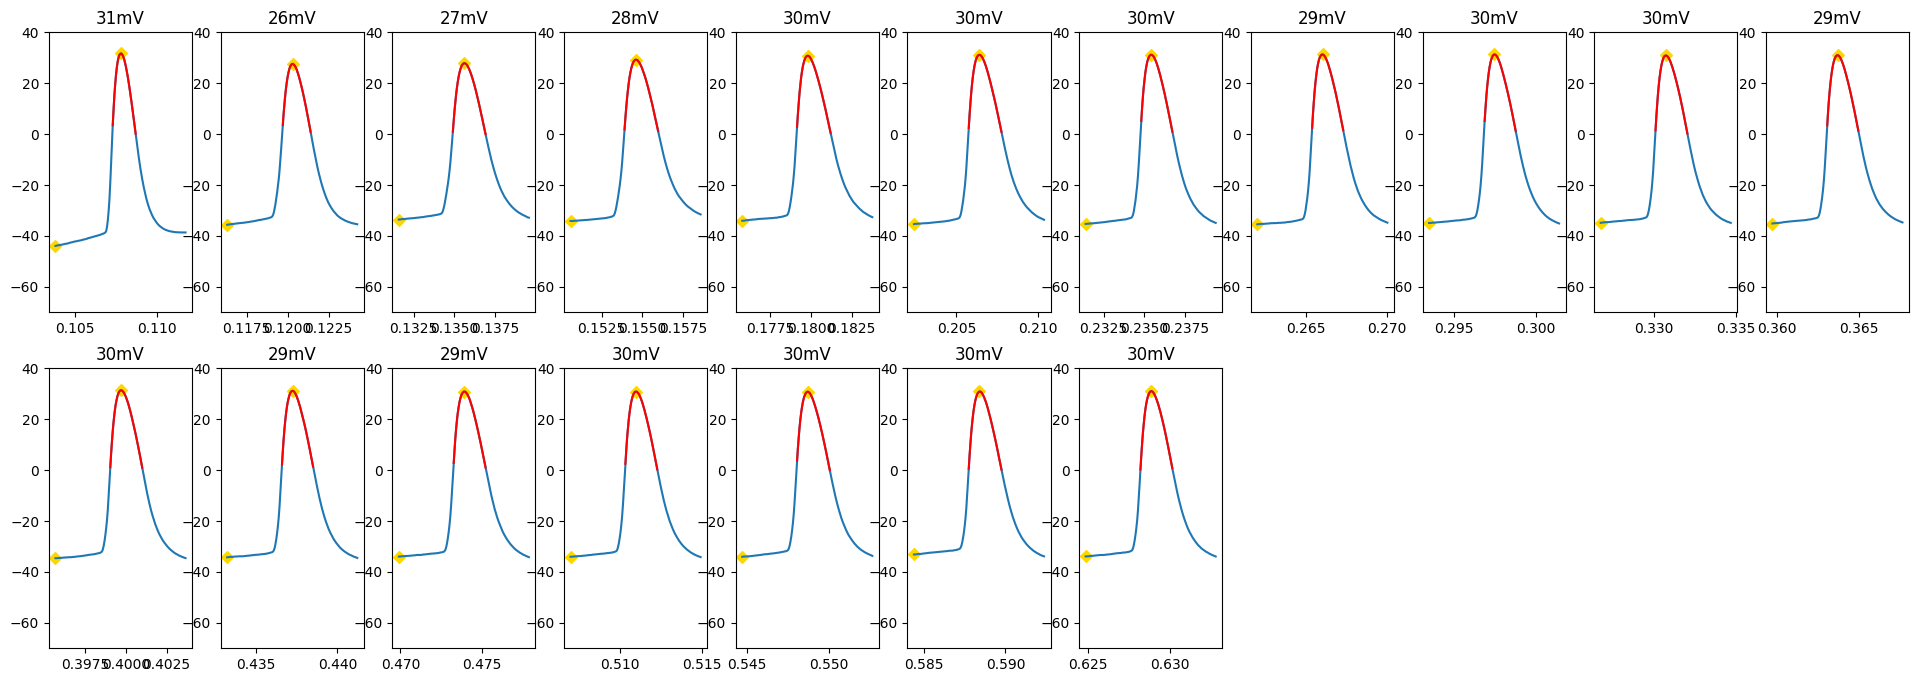

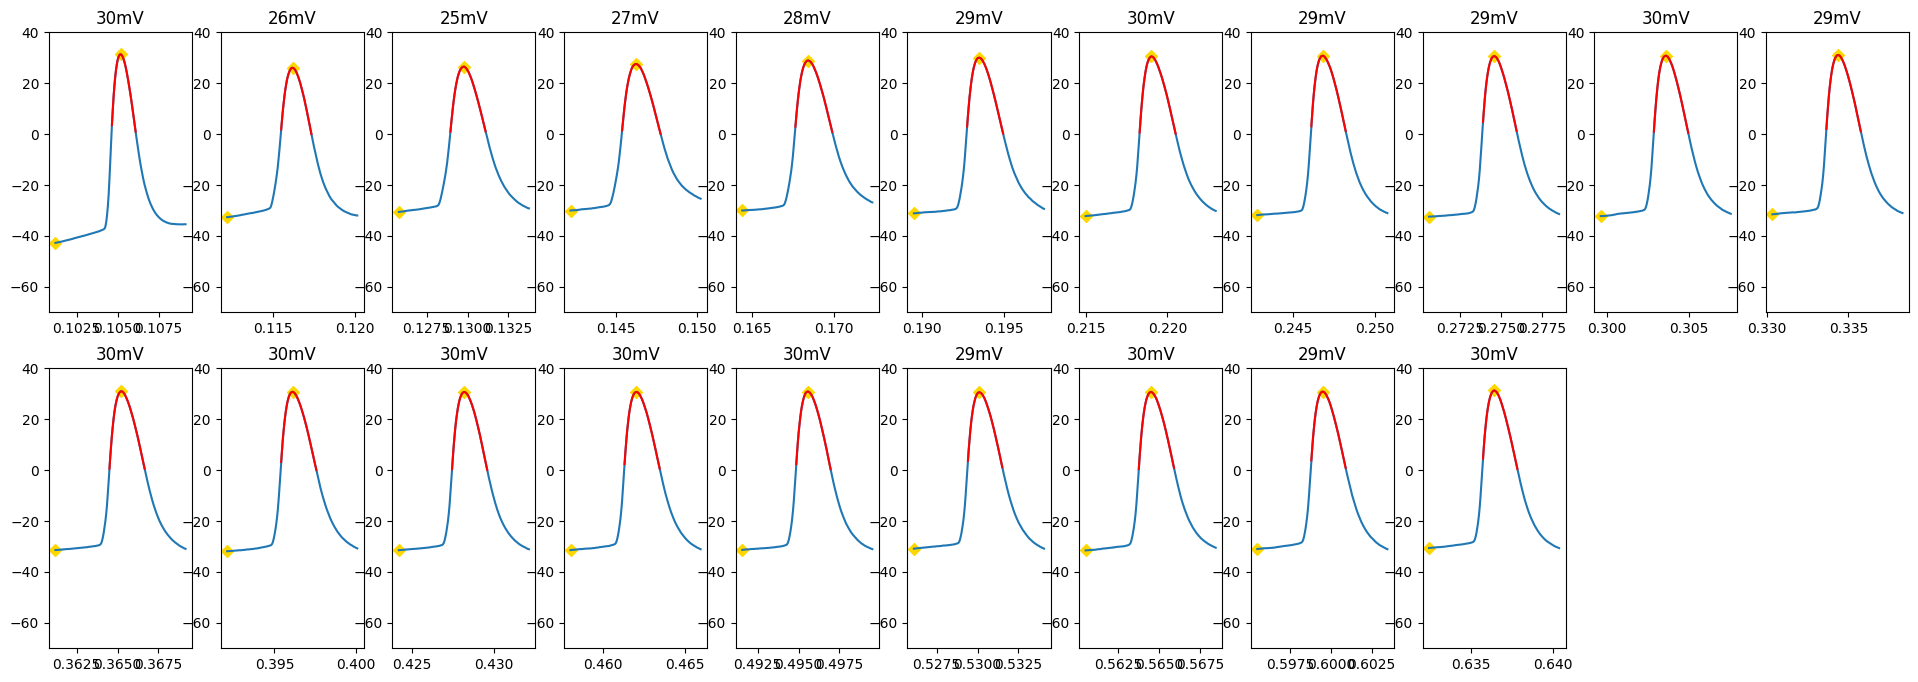

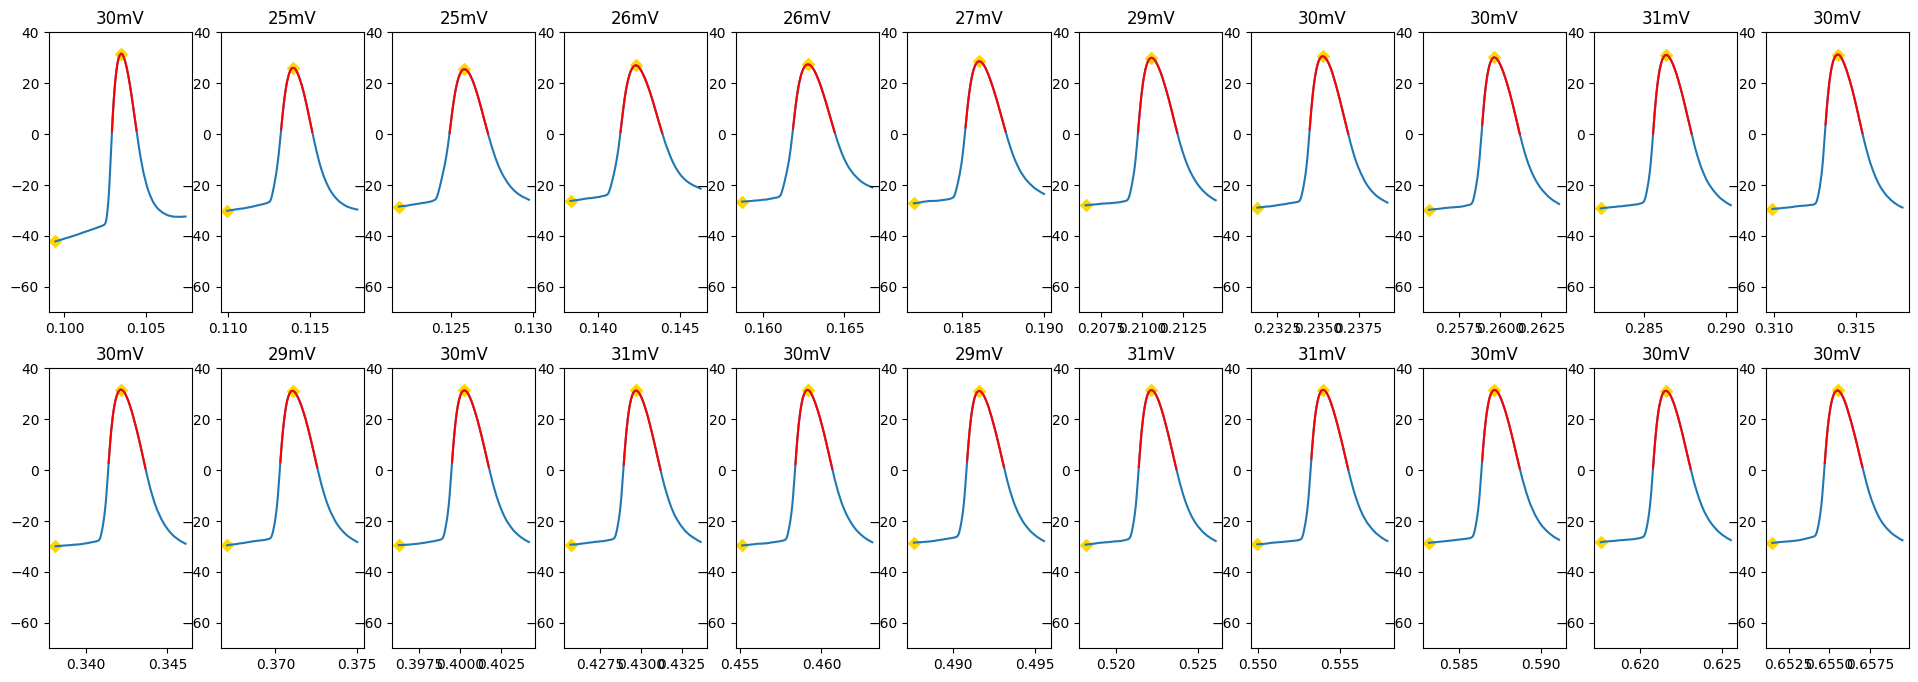

In [66]:
for n in range(9,16):
    # n = 13
    estimIndx = n*2 + 1
    respuesta = 'index_0{}'.format(n) if n<10 else 'index_{}'.format(n)
    estimulo  = 'index_0{}'.format(estimIndx) if estimIndx<10 else 'index_{}'.format(estimIndx)
    data = nwb_cp.acquisition[respuesta].data[:]
    stim = nwb_cp.stimulus[estimulo].data[:]

    pclamp = data
    picos = find_peaks(pclamp,prominence=20)[0]

    #   Impresion de picos en el tiempo
    fs = nwb_cp.acquisition['index_15'].rate
    tiempo = np.linspace(0,len(pclamp)/fs,len(pclamp))

    p_amp = pclamp[picos]
    p_tmp = tiempo[picos]

    #   Deteccion de voltaje de disparo
    plt.figure(figsize=(24,8))
    anch_vent = ( .008 * fs )

    for m in range(len(picos) - 1):
      plt.subplot(2, 11, m + 1)
      segmento_pclamp, segmento_tiempo = extraer_segmento(pclamp, tiempo, p_tmp[m], fs, anch_vent)

      paso_derivada = int(.001 * fs)
      umbral_val, umbral_pos = deteccion_umbral_dvdt(segmento_pclamp, paso_derivada)
      pico_forma, pico_tiempo = extraer_pico(segmento_pclamp, segmento_tiempo, umbral_val)
      r_time, d_time, p_ancho, p_amplitud = atributos_forma(pico_forma, pico_tiempo)
      plt.plot(segmento_tiempo, segmento_pclamp)
      plt.plot(pico_tiempo, pico_forma, color='red')
      plt.scatter(segmento_tiempo[umbral_pos], segmento_pclamp[umbral_pos], color='gold', marker='D')
      plt.scatter(p_tmp[m], p_amp[m], color='gold', marker='D')
      plt.title('{}mV'.format(int(p_amplitud)))
      plt.ylim(-70, 40)

**Extraer unicamente variables para analisis bioestadistico**

In [67]:
estadisticas = []
estad_estim  = []

for n in range(9,16):
    # n = 10
    estimIndx = n*2 + 1
    respuesta = 'index_0{}'.format(n) if n<10 else 'index_{}'.format(n)
    estimulo  = 'index_0{}'.format(estimIndx) if estimIndx<10 else 'index_{}'.format(estimIndx)
    data = nwb_cp.acquisition[respuesta].data[:]
    stim = nwb_cp.stimulus[estimulo].data[:]

    stim_val = np.abs(stim).max()
    stim_val = stim_val * -1 if min(stim) < 0 else stim_val

    pclamp = data
    picos = find_peaks(pclamp,prominence=20)[0]
    print(picos)

    #   Impresion de picos en el tiempo
    fs = nwb_cp.acquisition['index_15'].rate
    tiempo = np.linspace(0,len(pclamp)/fs,len(pclamp))

    p_amp = pclamp[picos]
    p_tmp = tiempo[picos]

    df_amplitud = []
    df_vdisparo = []
    df_pksancho = []
    df_raisetim = []
    df_decaytim = []

    #   Deteccion de voltaje de disparo
    anch_vent = ( .010 * fs )
    paso_derivada = int(.001*fs)

    for m in range(len(picos)):
        segmento_pclamp, segmento_tiempo = extraer_segmento(pclamp,tiempo,p_tmp[m],fs,anch_vent)
        umbral_val, umbral_pos = deteccion_umbral_dvdt(segmento_pclamp,paso_derivada)
        pico_forma, pico_tiempo = extraer_pico(segmento_pclamp,segmento_tiempo,umbral_val)
        r_time, d_time, p_ancho, p_amplitud = atributos_forma(pico_forma,pico_tiempo)

        df_amplitud.append(p_amplitud)
        df_vdisparo.append(umbral_val)
        df_pksancho.append(p_ancho)
        df_raisetim.append(r_time)
        df_decaytim.append(d_time)

    df = crear_df(df_amplitud,df_vdisparo,df_pksancho,df_raisetim,df_decaytim)
    estadisticas.append(df)
    estad_estim.append('{}pA'.format(stim_val))

[ 3373  4426  6752  9791 12760]
[ 2632  3083  3774  4800  6125  7498  8944 10509 12092 13593]
[ 2354  2693  3164  3795  4552  5438  6407  7364  8331  9344 10373 11398
 12479 13580]
[ 2233  2522  2905  3349  3928  4578  5302  6033  6807  7613  8415  9242
 10091 11009 11899 12796 13691]
[ 2156  2406  2712  3092  3596  4128  4708  5321  5949  6615  7274  7994
  8745  9478 10219 10974 11768 12577 13357]
[ 2104  2324  2596  2925  3368  3870  4380  4936  5492  6072  6687  7304
  7922  8564  9240  9911 10602 11290 11990 12728 13422]
[ 2069  2279  2516  2846  3255  3721  4211  4706  5193  5727  6278  6843
  7421  8005  8594  9183  9832 10443 11079 11743 12432 13110 13807]


**Generacion de DataFrames para medias y desviaciones estandard**

In [68]:
estadisticas

[    Amplitud  Voltaje de disparo  Ancho de pico  Tiempo de elevacion  \
 0  28.320312                   0        0.00090              0.00045   
 1  27.130127                   0        0.00095              0.00045   
 2  27.984619                   0        0.00095              0.00045   
 3  26.855469                   0        0.00095              0.00045   
 4  26.672363                   0        0.00090              0.00050   
 
    Tiempo de caida  
 0          0.00085  
 1          0.00090  
 2          0.00090  
 3          0.00085  
 4          0.00085  ,
     Amplitud  Voltaje de disparo  Ancho de pico  Tiempo de elevacion  \
 0  27.160645                   0        0.00090              0.00045   
 1  27.221680                   0        0.00105              0.00050   
 2  28.106689                   0        0.00110              0.00055   
 3  28.411865                   0        0.00110              0.00055   
 4  28.961182                   0        0.00105              

In [69]:
medias = [df.mean() for df in estadisticas]
stdevs = [df.std() for df in estadisticas]

medias = pd.DataFrame(medias,index=estad_estim)
stdevs = pd.DataFrame(stdevs,index=estad_estim)

estadisticas = medias, stdevs

In [70]:
estadisticas

(          Amplitud  Voltaje de disparo  Ancho de pico  Tiempo de elevacion  \
 100.0pA  27.392578                 0.0       0.000930             0.000460   
 150.0pA  28.005981                 0.0       0.001030             0.000505   
 200.0pA  29.170444                 0.0       0.001132             0.000536   
 250.0pA  29.822855                 0.0       0.001218             0.000565   
 300.0pA  29.834948                 0.0       0.001300             0.000603   
 350.0pA  29.514858                 0.0       0.001421             0.000683   
 400.0pA  29.633896                 0.0       0.001526             0.000741   
 
          Tiempo de caida  
 100.0pA         0.000870  
 150.0pA         0.000960  
 200.0pA         0.001068  
 250.0pA         0.001188  
 300.0pA         0.001274  
 350.0pA         0.001374  
 400.0pA         0.001487  ,
          Amplitud  Voltaje de disparo  Ancho de pico  Tiempo de elevacion  \
 100.0pA  0.722371                 0.0       0.000027          

**Diagramas de fase**

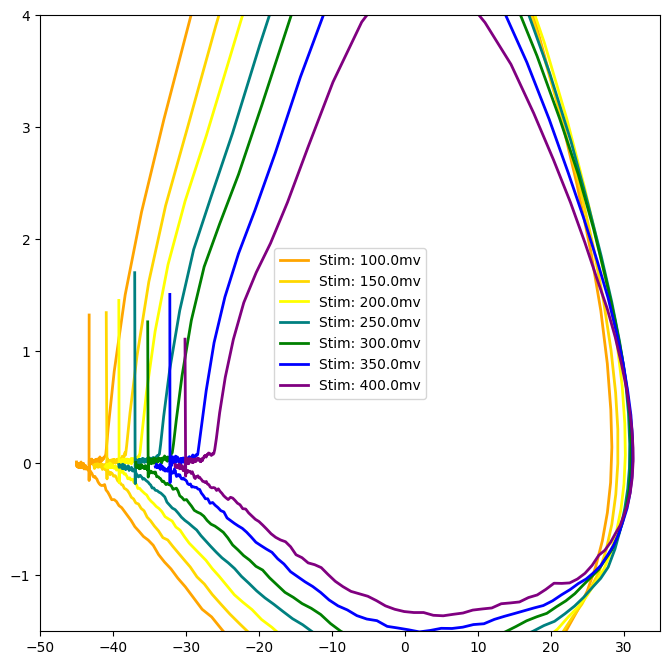

In [71]:
plt.figure(figsize=(8,8))
colores = ['red','orange','gold','yellow','teal','green','blue','purple','black','pink','violet','brown','gray']
legends = []

for n in range(9,16):
    estimIndx = n*2 + 1
    respuesta = 'index_0{}'.format(n) if n<10 else 'index_{}'.format(n)
    estimulo  = 'index_0{}'.format(estimIndx) if estimIndx<10 else 'index_{}'.format(estimIndx)
    data = nwb_cp.acquisition[respuesta].data[:]
    stim = nwb_cp.stimulus[estimulo].data[:]

    stim_val = np.abs(stim).max()
    stim_val = stim_val * -1 if min(stim) < 0 else stim_val

    legends.append('Stim: {}mv'.format(stim_val))

    pclamp = data
    picos = find_peaks(pclamp,prominence=20)[0]

    #   Impresion de picos en el tiempo
    fs = nwb_cp.acquisition['index_15'].rate
    tiempo = np.linspace(0,len(pclamp)/fs,len(pclamp))

    p_amp = pclamp[picos]
    p_tmp = tiempo[picos]

    anch_vent = ( .015/2 * fs )

    for m in range(len(picos)-2,len(picos)-1): # Hacer comienzar en 1 para ver el ciclo completo
        p_inicio = int(p_tmp[m]*fs - anch_vent)
        p_final  = int(p_tmp[m]*fs + anch_vent)
        segmento_pclamp = pclamp[p_inicio:p_final]

        paso_derivada = 1
        p_der = derivada(segmento_pclamp,paso_derivada)

        volt_suav = savgol_filter(segmento_pclamp[::paso_derivada][:-1],7,2)
        dvdt_suav = savgol_filter(p_der,7,2)
        plt.plot(volt_suav,dvdt_suav,linewidth=2,color=colores[int(len(legends))])
    plt.ylim(-1.5,4)
    plt.xlim(-50,35)

plt.legend(legends)